///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////                    

                                KRISSAAN AMEN ALLAH - M2 -TRIED                   

                                amenallahkrissane10@gmail.com                   

                            amen-allah.krissaan@telecom-sudparis.eu 
                            
                                        Lab 1- DEEP RN          

///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# TP 1 - Algorithme de rétro-propagation de l’erreur

**L’objectif de cette première séance de travaux pratiques est de vous faire implémenter par vous même l’apprentissage de réseaux de neurones simples.**
Cettre prise en main sera très formatrice pour utiliser des modèles plus évolués, et comprendre le fonctionnement des libaries (comme Keras) où l’apprentissage est automatisé.

On va travailler avec la base de données image MNIST, constituée d’images de
caractères manuscrits (60000 images en apprentissage, 10000 en test).

Voici un bout de code pour récupérer les données  :

In [1]:
#! pip install keras
#! pip install tensorflow

In [2]:
from keras.datasets import mnist
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


## Exercice 0 : visualisation de quelques images de la base
<dl style='margin: 20px 0;'>
<dt>Nous commencerons par afficher les 200 premières images de la base d’apprentissage.</dt>
<dd>
    
- Écrire un script qui récupère les données avec le code précédent.  
- Compléter pour permettre l’affichage demandé en utilisant le code suivant :  

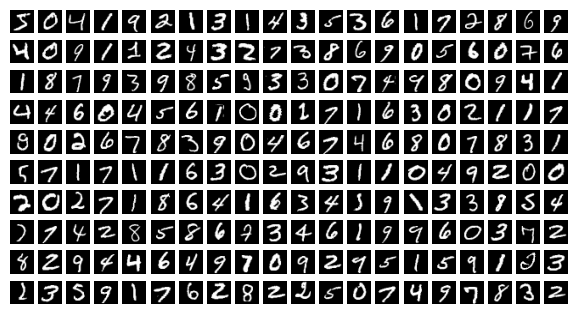

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.figure(figsize=(7.195, 3.841), dpi=100)
for i in range(200):
  plt.subplot(10,20,i+1)
  plt.imshow(X_train[i,:].reshape([28,28]), cmap='gray')
  plt.axis('off')
plt.show()

---
## Question :

Quel est l’espace dans lequel se trouvent les images ? Quel est sa taille ?

            l'espace c'est l'ensemble du Train et la taille c'est 28 * 28 



---

## Exercice 1 : Régression Logistique

### Modèle de prédiction


<dl style='margin: 20px 0;'>
<dt>On va d’abord commencer par créer un modèle de classification linéaire populaire, la régression logistique.</dt>
<dd>
Ce modèle correspond à un réseau de neurones à une seule couche, qui va projeter le vecteur d’entrée $ \mathbf{x_i} $ pour une image MNIST
(taille $ 28^2=784 $) avec un vecteur de de paramètres $ \mathbf{w_{c}} $ pour chaque classe (plus un biais $ b_c $).
Pour correspondre à la matrice des données de l’exercice précédent, on considère que chaque exemple $ \mathbf{x_i} $ est un vecteur ligne - taille (1,784).
En regroupant l’ensemble des jeux de paramètres $ \mathbf{w_{c}} $ pour les 10 classes dans une matrice $ \mathbf{W} $ (taille $ 784\times 10 $),
et les biais dans un vecteur $ \mathbf{b} $, on obtient un vecteur
$ \mathbf{\hat{s_i}} =\mathbf{x_i}  \mathbf{W}  + \mathbf{b} $ de taille (1,10).
Une fonction d’activation de type soft-max sur $ \mathbf{\hat{y_i}} = $ `softmax` $ (\mathbf{s_i}) $ permet d’obtenir le vecteur de sortie prédit par le modèle $ \mathbf{\hat{y_i}} $
- de taille (1,10) - qui représente la probabilité *a posteriori*
$ p(\mathbf{\hat{y_i}} | \mathbf{x_i}) $ pour chacune des 10 classes:

</dd>

</dl>


<a id='equation-softmax'></a>
$$
p(\hat{y_{c,i}} | \mathbf{x_i}) ) = \frac{e^{\langle \mathbf{x_i} ; \mathbf{w_{c}}\rangle + b_{c}}}{\sum\limits_{c'=1}^{10} e^{\langle \mathbf{x_i} ; \mathbf{w_{c'}}\rangle + b_{c'}}} \tag{1}
$$

Le schéma ci-dessous illustre le modèle de régression logistique avec un réseau de neurones.

<img src="http://cedric.cnam.fr/~thomen/cours/US330X/_images/LR.png" style="height:150px;" align="center">

- Quel est le nombre de paramètres du modèle ? Justifier le calcul.  

                (784+1)*10 = 7850

### Formulation du problème d’apprentissage

> Afin d’entraîner le réseau de neurones, on va comparer, pour chaque exemple d’apprentissage, la sortie prédite $ \mathbf{\hat{y_i}} $ par le réseau
(équation [(1)](#equation-softmax)) pour l’image $ \mathbf{x_i} $, avec la sortie
réelle $ \mathbf{y_i^*} $ issue de la supervision qui correspond à la catégorie de l’image $ \mathbf{x_i} $:
on utilisera en encodage de type « one-hot » pour $ \mathbf{y_i^*} $, *i.e.* :



<a id='equation-one-hot'></a>
$$
y_{c,i}^* =
 \begin{cases}
   1 & \text{si c correspond à l'indice de la classe de } \mathbf{x_i}  \\
   0 & \text{sinon}
 \end{cases} \tag{2}
$$

Pour mesurer l’erreur de prédiction, on utilisera une fonction de coût de type entropie croisée (« cross-entropy ») entre $ \mathbf{\hat{y_i}} $ et $ \mathbf{y_i^*} $
(l’entropie croisée est lié à la divergence de Kullback-Leiber, qui mesure une dissimilarité entre distributions de probabilités) :
$ \mathcal{L}(\mathbf{\hat{y_i}}, \mathbf{y_i^*}) = -\sum\limits_{c=1}^{10} y_{c,i}^* log(\hat{y}_{c,i}) = - log(\hat{y}_{c^*,i}) $, où $ c^* $ correspond à l’indice de la classe donné par la supervision pour l’image $ \mathbf{x_i} $.

La fonction de coût finale consistera à moyenner l’entropie croisée sur l’ensemble de la base d’apprentissage $ \mathcal{D} $ consistuée de $ N=60000 $ images :


<a id='equation-ce'></a>
$$
\mathcal{L}_{\mathbf{W},\mathbf{b}}(\mathcal{D})  = - \frac{1}{N}\sum_{i=1}^{N} log(\hat{y}_{c^*,i}) \tag{3}
$$

---

### Question :

La fonction de coût de l’Eq. [(3)](#equation-ce) est-elle convexe par rapports aux paramètres $ \mathbf{W} $, $ \mathbf{b} $ du modèle ? Avec un pas de gradient bien choisi, peut-on assurer la convergence vers le minimum  global de la solution ?

                Somme de fonction convexe est convexe.

---

### Optimisation du modèle

Afin d’optimiser les paramètres $ \mathbf{W} $ et $ \mathbf{b} $ du modèle de régression logistique par descente de gradient, on va utiliser la règle des dérivées chaînées (chain rule) :

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W}} =  \frac{1}{N}\sum_{i=1}^{N} \frac{\partial \mathcal{L}}{\partial \mathbf{\hat{y_i}}}  \frac{\partial \mathbf{\hat{y_i}}}{\partial \mathbf{s_i}} \frac{\partial \mathbf{s_i}}{\partial \mathbf{W}}
$$

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{b}} =  \frac{1}{N}\sum_{i=1}^{N} \frac{\partial \mathcal{L}}{\partial \mathbf{\hat{y_i}}}  \frac{\partial \mathbf{\hat{y_i}}}{\partial \mathbf{s_i}} \frac{\partial \mathbf{s_i}}{\partial \mathbf{b}}
$$

### Montrer que :

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{s_i}} = \mathbf{\delta^y_i}  =\frac{\partial \mathcal{L}}{\partial \mathbf{\hat{y_i}}}  \frac{\partial \mathbf{\hat{y_i}}}{\partial \mathbf{s_i}} = \mathbf{\hat{y_i}} - \mathbf{y_i^*}
$$

### En déduire que les gradients de $ \mathcal{L} $ par rapport aux paramètres du modèle s’écrivent :


<a id='equation-gradientw-LR'></a>
$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W}} = \frac{1}{N} \mathbf{X}^T (\mathbf{\hat{Y}} - \mathbf{Y^*}) = \frac{1}{N} \mathbf{X}^T \mathbf{\Delta^y} \tag{4}
$$


<a id='equation-gradientb-LR'></a>
$$
\frac{\partial \mathcal{L}}{\partial \mathbf{b}} = \frac{1}{N}\sum_{i=1}^{N}(\mathbf{\hat{y_i}} - \mathbf{y_i^*}) \tag{5}
$$

Où  $ \mathbf{X} $ est la matrice des données (taille $ 60000\times 784 $), $ \mathbf{\hat{Y}} $ est la matrice des labels prédits sur l’ensemble de la base d’apprentissage (taille $ 60000\times 10 $)
et $ \mathbf{Y^*} $ est la matrice des labels donnée issue de la supervision (« ground truth », taille $ 60000\times 10 $), et $ \mathbf{\Delta^y}=\mathbf{\hat{Y}}-\mathbf{Y^*} $.

### Implémentation de l’apprentissage

Les gradients aux équations [(4)](#equation-gradientw-LR) et [(5)](#equation-gradientb-LR) s’écrivent sous forme « vectorielle », ce qui va rendre les calculs efficaces avec des librairies de calculs scientifique comme `numpy`. Après calcul du gradient, les paramètres
seront mis à jour de la manière suivante :


<a id='equation-gradientupdatew'></a>
$$
\mathbf{W}^{(t+1)} = \mathbf{W}^{(t)} - \eta \frac{\partial \mathcal{L}}{\partial \mathbf{W}} \tag{6}
$$


<a id='equation-gradientupdateb'></a>
$$
\mathbf{b}^{(t+1)} = \mathbf{b}^{(t)} - \eta \frac{\partial \mathcal{L}}{\partial \mathbf{b}} \tag{7}
$$

où $ \eta $ est le pas de gradient (learning rate).

Pour implémenter l’algorithme d’apprentissage, on utuilisera une descente de gradient stochastique, c’est à dire que les gradients aux équations [(4)](#equation-gradientw-LR) et [(5)](#equation-gradientb-LR)  ne seront pas calculés
sur l’ensemble des $ N=60000 $ images d’apprentissage, mais sur un sous ensemble appelé **batch**. Cette technique permet une mise à jour des paramètres plus fréquente qu’avec une descente de gradient classique, et une convergence
plus rapide (au détriment d’un calcul de gradient approximé).

**On demande de mettre en place un script** `exo1.py` **qui implémente l’alogorithme de régression logistique sur la base MNIST.**

Après avoir chargé les données (exercice 0), on utilisera le code suivant pour générer des labels au format
0-1 encoding - équation [(2)](#equation-one-hot).

In [4]:
from tensorflow.keras.utils import to_categorical
K=10
# convert class vectors to binary class matrices
Y_train = to_categorical(y_train, K)
Y_test = to_categorical(y_test, K)

**On pourra utiliser la fonction suivante pour calculer la fonction softmax sur chaque élément de de la matrice de la projection linéraire (taille 𝑡𝑏×10) :**

In [5]:
def softmax(X):
    # Input matrix X of size Nbxd - Output matrix of same size
    E = np.exp(X)
    return (E.T / np.sum(E,axis=1)).T

## On mettra alors en place un code dont le squellette est donné ci-dessous :

In [6]:
import numpy as np

# Assume X_train and K are defined before this point

N = X_train.shape[0]
d = X_train.shape[1]

# Initialize weights and biases
W = np.zeros((d, K))
b = np.zeros((1, K))

numEp = 20  # Number of epochs for gradient descent
eta = 1e-1  # Learning rate
batch_size = 100
nb_batches = int(float(N) / batch_size)

def forward(x,w,b):
  Z=np.dot(x,w)+b
  return softmax(Z)

for epoch in range(numEp):
    for ex in range(nb_batches):
        # FORWARD PASS: compute prediction with current params for examples in batch
        batch_X = X_train[ex * batch_size: (ex + 1) * batch_size, :]
        batch_Y = Y_train[ex * batch_size: (ex + 1) * batch_size, :]

        scores = np.dot(batch_X, W) + b
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # BACKWARD PASS:
        # 1) compute gradients for W and b
        dscores = probs - batch_Y
        gradW = np.dot(batch_X.T, dscores)/batch_size
        gradb = np.sum(dscores, axis=0, keepdims=True)/batch_size

        # 2) update W and b parameters with gradient descent
        W -= eta * gradW
        b -= eta * gradb

# After the training loop, W and b will contain the learned parameters.


Pour compléter ce code, vous devez :

- Mettre en place une fonction `forward(batch, W, b)` qui va calculer la prédiction pour un batch de données. La fonction `forward` sera appelée pour chaque itération de la double boucle précédente.  


> - Si on considère un batch des données de taille $ tb\times 784 $, les paramètres $ \mathbf{W} $ (taille $ 784\times 10 $) et $ \mathbf{b} $ (taille $ 1\times 10 $), la fonction `forward` renvoie la prédiction $ \mathbf{\hat{Y}} $ sur le batch (taille $ tb\times 10 $).    

- Compléter le code pour la passe backward, consistant à  :
  - Calculer les gradient comme indiqué aux équations [(4)](#equation-gradientw-LR) et [(5)](#equation-gradientb-LR).
  - Mettre à jour les paramètres par descente de gradient comme indiqué aux équations [(6)](#equation-gradientupdatew) et [(7)](#equation-gradientupdateb).  


Enfin vous pouvez utiliser la fonction `accuracy(W, b, images, labels)` fournie pour calculer le taux de bonne reconnaissance du modèle. Ceci permettra de mesurer l’évolution des performances au cours des époques de l’algorithme d’apprentissage, et sur la base de test une fois le modèle appris.

### Vous devez obtenir un score de l’ordre de 92% sur la base de test pour ce modèle de régression logistique.

In [7]:
def accuracy(W, b, images, labels):
  pred = forward(images, W,b )
  return np.where( pred.argmax(axis=1) != labels.argmax(axis=1) , 0.,1.).mean()*100.0

# Supposons que vous ayez déjà défini les variables W, b, X_test, et Y_test
# où X_test est votre ensemble de test et Y_test sont les étiquettes correspondantes.

# Utilisez la fonction accuracy
acc = accuracy(W, b, X_train, Y_train)
acc1 = accuracy(W, b, X_test, Y_test)

# Imprimez le résultat
print("Accuracy: {:.2f}%".format(acc))
print("Accuracy: {:.2f}%".format(acc1))

Accuracy: 92.50%
Accuracy: 92.24%


## Exercice 2 : Perceptron multi-couches (MLP)

### L’objectif de ce second exercice est d’étendre le modèle de régression logistique afin de mettre en place des modèles de prédictions plus riches.
**En particulier, on va s’intéresser aux Perceptron multi-couches (Multi-Layer Percpetron, MLP)**. Contrairement à la régression logistique qui se limite à des séparateurs linéaires,
le Perceptron permet l’apprentissage de frontières de décisions non linéaires, et constituent des approximateurs universels de fonctions.

L’objectif de la séance de travaux pratiques est de mettre en place le code pour effectuer des prédictions et entraîner un Perceptron à une couche cachée.

### Prédiction avec un Perceptron (Forward)

L’architecture du perpcetron à une couche cachée est montrée à la figure ci-dessous.

<img src="http://cedric.cnam.fr/~thomen/cours/US330X/_images/MLP.png" style="height:250px;" align="center">

Si on considère les données de la base MNIST, chaque image est représentée par un vecteur de taille $ 28^2=784 $.
Le perpcetron va effecteur les différentes étape de transformation pour produire la prédiction finale, *i.e.* la catégorie sémantique de l’image :

- Une étape de projection linéaire, qui va projeter chaque image sur un vecteur de taille $ (1,L) $, *e.g.* $ L=100 $. En considérant chaque exemple $ \mathbf{x_i} $ est un vecteur ligne - taille $ (1,784) $ - la projection linéaire peut être représentée par la matrice $ \mathbf{W^h} $ (taille $ (784, L) $), et le vecteur de biais $ \mathbf{b^h} $ (taille $ (1, L) $) : $ \mathbf{\hat{u_i}} =\mathbf{x_i}  \mathbf{W^h}  + \mathbf{b^h} $.  


> - Une étape de non linéarité, *e.g.* de type sigmoïde :  $ \forall j \in  \left\lbrace 1; L \right\rbrace  ~ h_{i,j} = \frac{1}{1+exp(-u_{i,j})} $  



- Une seconde étape de projection linéaire, qui va projeter le vecteur latent de taille $ (1,L) $ sur un vecteur de taille $ (1,K)=10 $ (nombre de classes). Cette opération de projection linéaire sera représentée par la matrice $ \mathbf{W^y} $ (taille $ (L, K) $), et le vecteur de biais $ \mathbf{b^y} $ (taille $ (1, K) $) : $ \mathbf{\hat{v_i}} =\mathbf{h_i}  \mathbf{W^y}  + \mathbf{b^y} $.  


> - Une étape de non linéarité de type soft-max vue la semaine précédente pour la régression logistique : $ \forall j \in  \left\lbrace 1; K \right\rbrace  ~ y_{i,j} = \frac{exp(v_{i,j})}{\sum\limits_{i=1}^K exp(v_{i,k})} $  



**On demande de mettre en place un script** `mlp.py` **qui implémente l’alogorithme du Percpetron sur la base MNIST.**


<dl style='margin: 20px 0;'>
<dt>L’algorithme reprendra le squelette du code de la régression logistique. Pour adapter ce code pour le Perceptron pour la partie prédiction,  vous devez :</dt>
<dd>
- Modifier la fonction de prédiction, afin disposer la fonction `forward(batch, Wh, bh, Wy, by)` qui reverra à la fois la prédiction pour le batch ainsi que la matrice des couches latentes.  


> - Si on considère un batch des données de taille $ t_b\times 784 $, les paramètres $ \mathbf{W^h} $ (taille $ 784\times L $), $ \mathbf{b^h} $ (taille $ 1\times L $), $ \mathbf{W^y} $ (taille $ L\times K $) et $ \mathbf{b^y} $ (taille $ 1\times K $), la fonction `forward` renvoie la prédiction $ \mathbf{\hat{Y}} $ sur le batch (taille $ t_b\times K $) et la matrice de variables latentes (taille $ t_b\times L $).  



</dd>

</dl>

In [8]:
# Function forward pour le MLP
def forward(batch, Wh, bh, Wy, by):
    latent = 0
    res = 0
    return latent, res

In [9]:
# Calcul de l'accuracy avec le MLP
def accuracy(batch, labels,Wh, bh, Wy, by):
   latent, pred = forward(batch, Wh, bh, Wy, by)
   return np.where( pred.argmax(axis=1) != labels.argmax(axis=1) , 0.,1.).mean()*100.0

### Apprentissage du Perceptron (Backward)

Afin d’entraîner le Perceptron, on va utiliser l’algorithme de rétro-propagation de l’erreur. On rappelle que pour chaque batch d’exemples, l’algorithme va effectuer une passe `forward` (Exercice 1), permettant de calculer la prédiction du réseau.
Une fonction de coût (ici l’entropie croisée) entre la sortie prédite et la la sortie donnée par la supervision va permettre de calculer le gradient de l’erreur par rapport à tous les paramètres paramètres du modèle, *i.e.* $ \mathbf{W^y} $ (taille $ (L, K) $), $ \mathbf{b^y} $ (taille $ (1, K) $), $ \mathbf{W^h} $ (taille $ (784, L) $), et $ \mathbf{b^h} $ (taille $ (1, L) $).

On rappelle les équation des gradients, effectuées depuis le haut vers le bas du réseau :

1. Mise à jour de $ \mathbf{W^y} $ et $ \mathbf{b^y} $ :  


$$
\frac{\partial \mathcal{L}}{\partial \mathbf{v_i}} = \mathbf{\delta^y_i} = \mathbf{\hat{y_i}} - \mathbf{y_i^*}
$$


<a id='equation-gradientw'></a>
$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W^y}} = \frac{1}{t_b}\mathbf{H}^T (\mathbf{\hat{Y}} - \mathbf{Y^*}) = \frac{1}{t_b} \mathbf{H}^T \mathbf{\Delta^y} \tag{8}
$$


<a id='equation-gradientb'></a>
$$
\frac{\partial \mathcal{L}}{\partial \mathbf{b^y}} = \frac{1}{t_b}\sum_{i=1}^{t_b}(\mathbf{\hat{y_i}} - \mathbf{y_i^*}) \tag{9}
$$

Où  $ \mathbf{H} $ est la matrice des couches cachées sur le batch (taille $ t_b\times L $), $ \mathbf{\hat{Y}} $ est la matrice des labels prédits sur l’ensemble de la base d’apprentissage (taille $ t_b\times K $)
et $ \mathbf{Y^*} $ est la matrice des labels donnée issue de la supervision (« ground truth », taille $ t_b\times K $), et $ \mathbf{\Delta^y}=\mathbf{\hat{Y}}-\mathbf{Y^*} $.

1. Mise à jour de $ \mathbf{W^h} $ et $ \mathbf{b^h} $ :  


$$
\frac{\partial \mathcal{L}}{\partial \mathbf{u_i}} = \mathbf{\delta^h_i} = \mathbf{\delta^y_i} \mathbf{W^{y}}^T   \odot \sigma^{'}(\mathbf{u_i}) = \mathbf{\delta^y_i} \mathbf{W^{y}}^T \odot (\mathbf{h_i} \odot (1-\mathbf{h_i}))
$$

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W^h}} =  \frac{1}{t_b} \mathbf{X}^T \mathbf{\Delta^h}
$$

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{b^h}} = \frac{1}{t_b}\sum_{i=1}^{t_b}(\delta^h_i)
$$

Où  $ \mathbf{X} $ est la matrice des données sur le batch (taille $ t_b\times 784 $), et $ \mathbf{\Delta^h} $ est la matrice des $ \delta^h_i $ sur le batch (taille $ t_b\times L $).

## Adapter la partie backward de l’algorithme pour entraîner le Perceptron.
On Choisira un pas de gradient $ \eta=1.0 $ et 100 époques.

In [10]:
# tester les performances methode Mohamed Boukaf

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def forward(batch, Wh, bh, Wy, by):
    """ Entrées:
        - batch: un batch de n images de MNIST au format vecteur (n, 784)
        - Wh: une matrice de poids entrée -> couche cachée
        - bh: un vecteur de biais pour la couche cachée
        - Wy: une matrice de poids couche cachée -> sortie
        - by: un vecteur de biais pour la sortie

        Renvoie:
        - Y_pred: prédictions de sortie
        - H: activations de la couche cachée
    """
    # À compléter
    H = sigmoid(batch @ Wh + bh)
    Y_pred=softmax(H@Wy+by)
    return Y_pred, H


def backward(Y_pred, Y, X, H,Wy):
    """ Entrées:
        - Y_pred: batch de vecteur des prédictions (one-hot)
        - Y: batch de vecteur des étiquettes (one-hot)
        - X: batch d'images (au format vectoriel (n, 784))
        - H: matrice des activations cachées

        Renvoie:
        - gradWy: gradient de l'erreur (entropie croisée) par rapport à Wy
        - gradby: gradient de l'erreur (entropie croisée) par rapport à by
        - gradWh: gradient de l'erreur (entropie croisée) par rapport à Wh
        - gradbh: gradient de l'erreur (entropie croisée) par rapport à bh
    """
    n = len(X)

    # Calcul du gradient par rapport à Wy et by
    grad_output = Y_pred - Y
    gradWy = np.dot(H.T, grad_output)
    gradby = np.sum(grad_output, axis=0, keepdims=True)

    # Calcul du gradient par rapport à Wh et bh
    grad_hidden = np.dot(grad_output, Wy.T) * (H * (1 - H))
    gradWh = np.dot(X.T, grad_hidden)
    gradbh = np.sum(grad_hidden, axis=0, keepdims=True)

    # Normalisation des gradients par le nombre d'exemples
    gradWy /= n
    gradby /= n
    gradWh /= n
    gradbh /= n

    return gradWy, gradby, gradWh, gradbh


def accuracy_mlp( images, labels,wh, bh, wy, by):
    pred, h = forward(images, wh, bh, wy, by)
    return np.where(pred.argmax(axis=1) != labels.argmax(axis=1), 0., 1.).mean()*100.0

def acc(X_batch,Y_batch,wh,bh,wy,by):
    pred,h=forward(X_batch,wh,bh,wy,by)
    predicted_labels = np.argmax(pred, axis=1)
    true_labels = np.argmax(Y_batch, axis=1)
    accuracy = np.mean(predicted_labels==true_labels) * 100.0
    return accuracy


import numpy as np
N, d = X_train.shape # N exemples, dimension d
hidden_size = 100 # Nombre de neurones de la couche cachée
# Initialisation des poids et des biais
from sklearn.metrics import log_loss



Wy = np.zeros((hidden_size, K))
Wh = np.zeros((d, hidden_size))
by = np.zeros((1, K))
bh = np.zeros((1, hidden_size))

sigma_normal = 1/np.sqrt(784)
K = 10
L = 100
Wy = np.random.normal(0, sigma_normal,(L,K))
by = np.random.normal(0, sigma_normal,(1,K))
Wh = np.random.normal(0, sigma_normal,(d,L))
bh = np.random.normal(0, sigma_normal,(1,L))
eta=0.1


n_epochs = 100 # Nombre d'epochs de la descente de gradient
eta = 1e-1 # Learning rate (pas d'apprentissage)
batch_size = 100 # Taille du lot
n_batches = int(float(N) / batch_size)

# Allocation des matrices pour stocker les valeurs des gradients
gradWy = np.zeros((hidden_size, K))
gradWh = np.zeros((d, hidden_size))
gradby = np.zeros((1, K))
gradbh = np.zeros((1, hidden_size))
accuracy=[]
loss_train=[]
loss_test=[]

for epoch in range(n_epochs):
    for batch_idx in range(n_batches):
        X_batch = X_train[batch_idx * batch_size:(batch_idx + 1) * batch_size]
        Y_batch = Y_train[batch_idx * batch_size:(batch_idx + 1) * batch_size]

        # ********* À compléter **********
        # FORWARD PASS : calculer la prédiction y à partir des paramètres courants pour les images du batch
        Y_pred,H=forward(X_batch,Wh,bh,Wy,by)
        # BACKWARD PASS :
        gradWy, gradby, gradWh, gradbh=backward(Y_pred, Y_batch, X_batch, H,Wy)
        Wy=Wy-eta*gradWy
        by=by-eta*gradby
        Wh=Wh-eta*gradWh
        bh=bh-eta*gradbh


        # 1) calculer les gradients de l'erreur par rapport à W et b
        # 2) mettre à jour les paramètres W et b selon la descente de gradient
    logloss_train = log_loss(Y_batch, Y_pred)
    pred_test,h=forward(X_test,Wh,bh,Wy,by)
    logloss_test=log_loss(Y_test,pred_test)
    loss_train.append(logloss_train)
    loss_test.append(logloss_test)
    accur=acc(X_test,Y_test,Wh,bh,Wy,by)
    accuracy.append(accur)
    #print(f'======= Epoch {epoch}/{n_epochs}')
    print(f'======= Epoch {epoch}/{n_epochs} ======= Accuracy {accur}')



======= Epoch 0/100 ======= Accuracy 85.84
======= Epoch 1/100 ======= Accuracy 89.61
======= Epoch 2/100 ======= Accuracy 90.64
======= Epoch 3/100 ======= Accuracy 91.42
======= Epoch 4/100 ======= Accuracy 91.91
======= Epoch 5/100 ======= Accuracy 92.27
======= Epoch 6/100 ======= Accuracy 92.69
======= Epoch 7/100 ======= Accuracy 92.97
======= Epoch 8/100 ======= Accuracy 93.16
======= Epoch 9/100 ======= Accuracy 93.47999999999999
======= Epoch 10/100 ======= Accuracy 93.71000000000001
======= Epoch 11/100 ======= Accuracy 93.93
======= Epoch 12/100 ======= Accuracy 94.14
======= Epoch 13/100 ======= Accuracy 94.28999999999999
======= Epoch 14/100 ======= Accuracy 94.54
======= Epoch 15/100 ======= Accuracy 94.67999999999999
======= Epoch 16/100 ======= Accuracy 94.78
======= Epoch 17/100 ======= Accuracy 94.88
======= Epoch 18/100 ======= Accuracy 94.99
======= Epoch 19/100 ======= Accuracy 95.1
======= Epoch 20/100 ======= Accuracy 95.17
======= Epoch 21/100 ======= Accuracy 9

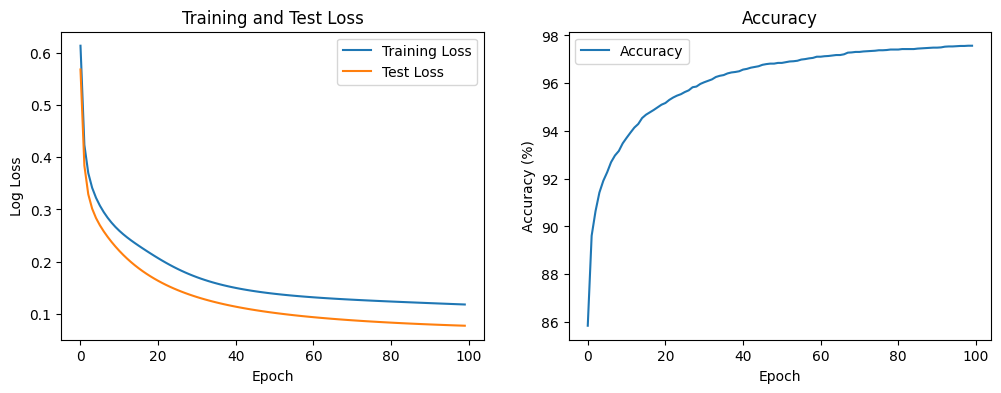

In [11]:
import matplotlib.pyplot as plt


# Plotting
epochs = range(n_epochs)

# Plot the training and test losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_train, label='Training Loss')
plt.plot(epochs, loss_test, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


---
# Observation : 

### Graphique de gauche : **Loss d'entraînement et de test**
- **Observation** : 
  - Les courbes de perte pour l'entraînement et le test diminuent rapidement au cours des premières époques, puis continuent à diminuer progressivement, atteignant des valeurs très basses (< 0,1).
  - La courbe de perte de test est toujours en dessous de la courbe de perte d'entraînement.

- **Analyse** : 
  - Le modèle apprend efficacement, comme en témoigne la diminution régulière des pertes.
  - La perte de test inférieure à celle de l'entraînement peut indiquer une certaine sous-régularisation ou des données d'entraînement moins complexes par rapport aux données de test.
  - L'absence de divergence significative entre les courbes indique une bonne généralisation.


### Graphique de droite : **Précision (Accuracy)**
- **Observation** : 
  - La précision augmente rapidement et atteint un plateau autour de 98 % après environ 50 époques.
  - La courbe est stable avec très peu de fluctuations.

- **Analyse** :
  - Une précision élevée (98 %) suggère que le modèle est bien adapté à la tâche.
  - Le plateau indique que le modèle a atteint sa performance maximale avec cette architecture et ces données.
  - Une précision aussi élevée pourrait être le signe d'un sur-apprentissage (overfitting) si les données sont trop spécifiques ou insuffisantes.



---

In [12]:
'''
# tester les performances avec initialisation des matrices des poids seulement a zero
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def forward(batch, Wh, bh, Wy, by):
    """ Entrées:
        - batch: un batch de n images de MNIST au format vecteur (n, 784)
        - Wh: une matrice de poids entrée -> couche cachée
        - bh: un vecteur de biais pour la couche cachée
        - Wy: une matrice de poids couche cachée -> sortie
        - by: un vecteur de biais pour la sortie

        Renvoie:
        - Y_pred: prédictions de sortie
        - H: activations de la couche cachée
    """
    # À compléter
    H = sigmoid(batch @ Wh + bh)
    Y_pred=softmax(H@Wy+by)
    return Y_pred, H


def backward(Y_pred, Y, X, H,Wy):
    """ Entrées:
        - Y_pred: batch de vecteur des prédictions (one-hot)
        - Y: batch de vecteur des étiquettes (one-hot)
        - X: batch d'images (au format vectoriel (n, 784))
        - H: matrice des activations cachées

        Renvoie:
        - gradWy: gradient de l'erreur (entropie croisée) par rapport à Wy
        - gradby: gradient de l'erreur (entropie croisée) par rapport à by
        - gradWh: gradient de l'erreur (entropie croisée) par rapport à Wh
        - gradbh: gradient de l'erreur (entropie croisée) par rapport à bh
    """
    n = len(X)

    # Calcul du gradient par rapport à Wy et by
    grad_output = Y_pred - Y
    gradWy = np.dot(H.T, grad_output)
    gradby = np.sum(grad_output, axis=0, keepdims=True)

    # Calcul du gradient par rapport à Wh et bh
    grad_hidden = np.dot(grad_output, Wy.T) * (H * (1 - H))
    gradWh = np.dot(X.T, grad_hidden)
    gradbh = np.sum(grad_hidden, axis=0, keepdims=True)

    # Normalisation des gradients par le nombre d'exemples
    gradWy /= n
    gradby /= n
    gradWh /= n
    gradbh /= n

    return gradWy, gradby, gradWh, gradbh


def accuracy_mlp( images, labels,wh, bh, wy, by):
    pred, h = forward(images, wh, bh, wy, by)
    return np.where(pred.argmax(axis=1) != labels.argmax(axis=1), 0., 1.).mean()*100.0

def acc(X_batch,Y_batch,wh,bh,wy,by):
    pred,h=forward(X_batch,wh,bh,wy,by)
    predicted_labels = np.argmax(pred, axis=1)
    true_labels = np.argmax(Y_batch, axis=1)
    accuracy = np.mean(predicted_labels==true_labels) * 100.0
    return accuracy


import numpy as np
N, d = X_train.shape # N exemples, dimension d
hidden_size = 100 # Nombre de neurones de la couche cachée
# Initialisation des poids et des biais
from sklearn.metrics import log_loss



Wy = np.zeros((hidden_size, K))
Wh = np.zeros((d, hidden_size))
by = np.zeros((1, K))
bh = np.zeros((1, hidden_size))

sigma_normal = 1/np.sqrt(784)
K = 10
L = 100

by = np.random.normal(0, sigma_normal,(1,K))
bh = np.random.normal(0, sigma_normal,(1,L))
eta=0.1


n_epochs = 100 # Nombre d'epochs de la descente de gradient
eta = 1e-1 # Learning rate (pas d'apprentissage)
batch_size = 100 # Taille du lot
n_batches = int(float(N) / batch_size)

# Allocation des matrices pour stocker les valeurs des gradients
gradWy = np.zeros((hidden_size, K))
gradWh = np.zeros((d, hidden_size))
gradby = np.zeros((1, K))
gradbh = np.zeros((1, hidden_size))
accuracy=[]
loss_train=[]
loss_test=[]

for epoch in range(n_epochs):
    for batch_idx in range(n_batches):
        X_batch = X_train[batch_idx * batch_size:(batch_idx + 1) * batch_size]
        Y_batch = Y_train[batch_idx * batch_size:(batch_idx + 1) * batch_size]

        # ********* À compléter **********
        # FORWARD PASS : calculer la prédiction y à partir des paramètres courants pour les images du batch
        Y_pred,H=forward(X_batch,Wh,bh,Wy,by)
        # BACKWARD PASS :
        gradWy, gradby, gradWh, gradbh=backward(Y_pred, Y_batch, X_batch, H,Wy)
        Wy=Wy-eta*gradWy
        by=by-eta*gradby
        Wh=Wh-eta*gradWh
        bh=bh-eta*gradbh


        # 1) calculer les gradients de l'erreur par rapport à W et b
        # 2) mettre à jour les paramètres W et b selon la descente de gradient
    logloss_train = log_loss(Y_batch, Y_pred)
    pred_test,h=forward(X_test,Wh,bh,Wy,by)
    logloss_test=log_loss(Y_test,pred_test)
    loss_train.append(logloss_train)
    loss_test.append(logloss_test)
    accur=acc(X_test,Y_test,Wh,bh,Wy,by)
    accuracy.append(accur)
    #print(f'======= Epoch {epoch}/{n_epochs}')
    print(f'======= Epoch {epoch}/{n_epochs} ======= Accuracy {accur}')

'''

'\n# tester les performances avec initialisation des matrices des poids seulement a zero\ndef sigmoid(x):\n    return 1 / (1 + np.exp(-x))\n\n\ndef forward(batch, Wh, bh, Wy, by):\n    """ Entrées:\n        - batch: un batch de n images de MNIST au format vecteur (n, 784)\n        - Wh: une matrice de poids entrée -> couche cachée\n        - bh: un vecteur de biais pour la couche cachée\n        - Wy: une matrice de poids couche cachée -> sortie\n        - by: un vecteur de biais pour la sortie\n\n        Renvoie:\n        - Y_pred: prédictions de sortie\n        - H: activations de la couche cachée\n    """\n    # À compléter\n    H = sigmoid(batch @ Wh + bh)\n    Y_pred=softmax(H@Wy+by)\n    return Y_pred, H\n\n\ndef backward(Y_pred, Y, X, H,Wy):\n    """ Entrées:\n        - Y_pred: batch de vecteur des prédictions (one-hot)\n        - Y: batch de vecteur des étiquettes (one-hot)\n        - X: batch d\'images (au format vectoriel (n, 784))\n        - H: matrice des activations cachée

## Questions :

- La fonction de coût de l’Eq. [(3)](tpDeepLearning1.ipynb#equation-ce) est-elle convexe par rapport aux paramètres $ \mathbf{W} $, $ \mathbf{b} $ du modèle ? Avec un pas de gradient bien choisi, peut-on assurer la convergence vers le minimum global de la solution ? 

            La fonction de coût pour un MLP est non convexe en raison des fonctions d'activation non linéaires. La convergence vers un minimum global n'est pas garantie, mais la descente de gradient peut trouver un bon minimum local.


- Tester en initialisant les matrices à 0 comme pour la régression logistique. Quelles performances obtenez-vous ? Que peut-on en conclure ?  




        L'initialisation des poids à 0 entraîne une symétrie dans les gradients, ce qui fait que tous les neurones d'une couche apprennent les mêmes caractéristiques. Cela conduit à de mauvaises performances.






- Vous testerez deux autres initialisations : une qui initialise les poids avec une loi normale de moyenne nulle et d’écart type à fixer, *e.g.* $ 10^-1 $, et une autre connue sous le nom de Xavier [[GB10]](#glorot10understandingthe), qui divise la valeur de la gaussienne par $ \sqrt{ni} $, où $ ni $ est le nombre de neurone dans la couche d’entrée.  
- Évaluer les performances du modèle. **Vous devez obtenir un score de l’ordre de 98% sur la base de test pour ce réseau de neurones à une couche cachée.**  


<a id='glorot10understandingthe'></a>
\[GB10\] Xavier Glorot and Yoshua Bengio. Understanding the difficulty of training deep feedforward neural networks. In *In Proceedings of the International Conference on Artificial Intelligence and Statistics (AISTATS’10). Society for Artificial Intelligence and Statistics*. 2010.



#Tester les performances avec initialisation de tous les matrices (W et b) a zero

In [13]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def forward(batch, Wh, bh, Wy, by):
    """ Entrées:
        - batch: un batch de n images de MNIST au format vecteur (n, 784)
        - Wh: une matrice de poids entrée -> couche cachée
        - bh: un vecteur de biais pour la couche cachée
        - Wy: une matrice de poids couche cachée -> sortie
        - by: un vecteur de biais pour la sortie

        Renvoie:
        - Y_pred: prédictions de sortie
        - H: activations de la couche cachée
    """
    # À compléter
    H = sigmoid(batch @ Wh + bh)
    Y_pred=softmax(H@Wy+by)
    return Y_pred, H


def backward(Y_pred, Y, X, H,Wy):
    """ Entrées:
        - Y_pred: batch de vecteur des prédictions (one-hot)
        - Y: batch de vecteur des étiquettes (one-hot)
        - X: batch d'images (au format vectoriel (n, 784))
        - H: matrice des activations cachées

        Renvoie:
        - gradWy: gradient de l'erreur (entropie croisée) par rapport à Wy
        - gradby: gradient de l'erreur (entropie croisée) par rapport à by
        - gradWh: gradient de l'erreur (entropie croisée) par rapport à Wh
        - gradbh: gradient de l'erreur (entropie croisée) par rapport à bh
    """
    n = len(X)

    # Calcul du gradient par rapport à Wy et by
    grad_output = Y_pred - Y
    gradWy = np.dot(H.T, grad_output)
    gradby = np.sum(grad_output, axis=0, keepdims=True)

    # Calcul du gradient par rapport à Wh et bh
    grad_hidden = np.dot(grad_output, Wy.T) * (H * (1 - H))
    gradWh = np.dot(X.T, grad_hidden)
    gradbh = np.sum(grad_hidden, axis=0, keepdims=True)

    # Normalisation des gradients par le nombre d'exemples
    gradWy /= n
    gradby /= n
    gradWh /= n
    gradbh /= n

    return gradWy, gradby, gradWh, gradbh


def accuracy_mlp( images, labels,wh, bh, wy, by):
    pred, h = forward(images, wh, bh, wy, by)
    return np.where(pred.argmax(axis=1) != labels.argmax(axis=1), 0., 1.).mean()*100.0

def acc(X_batch,Y_batch,wh,bh,wy,by):
    pred,h=forward(X_batch,wh,bh,wy,by)
    predicted_labels = np.argmax(pred, axis=1)
    true_labels = np.argmax(Y_batch, axis=1)
    accuracy = np.mean(predicted_labels==true_labels) * 100.0
    return accuracy


import numpy as np
from sklearn.metrics import log_loss

# Assurez-vous que les données X_train, Y_train, X_test, Y_test sont déjà chargées

N, d = X_train.shape # N exemples, dimension d
K = 10 # Nombre de classes
L = 100 # Nombre de neurones dans la couche cachée

# Initialisation des poids et des biais à zéro
Wh = np.zeros((d, L))
bh = np.zeros((1, L))
Wy = np.zeros((L, K))
by = np.zeros((1, K))

eta = 0.1 # Taux d'apprentissage

n_epochs = 100 # Nombre d'epochs
batch_size = 100 # Taille du lot
n_batches = N // batch_size

loss_train = []
loss_test = []
accuracy = []

for epoch in range(n_epochs):
    for batch_idx in range(n_batches):
        # Extraction des lots
        X_batch = X_train[batch_idx * batch_size:(batch_idx + 1) * batch_size]
        Y_batch = Y_train[batch_idx * batch_size:(batch_idx + 1) * batch_size]

        # Forward pass
        Y_pred, H = forward(X_batch, Wh, bh, Wy, by)

        # Backward pass
        gradWy, gradby, gradWh, gradbh = backward(Y_pred, Y_batch, X_batch, H, Wy)

        # Mise à jour des poids
        Wy -= eta * gradWy
        by -= eta * gradby
        Wh -= eta * gradWh
        bh -= eta * gradbh

    # Calcul et stockage des pertes et de la précision
    logloss_train = log_loss(Y_batch, Y_pred)
    pred_test, h = forward(X_test, Wh, bh, Wy, by)
    logloss_test = log_loss(Y_test, pred_test)
    accur = accuracy_mlp(X_test, Y_test, Wh, bh, Wy, by)

    loss_train.append(logloss_train)
    loss_test.append(logloss_test)
    accuracy.append(accur)

    print(f'Epoch {epoch+1}/{n_epochs} - Train Loss: {logloss_train:.4f} - Test Loss: {logloss_test:.4f} - Accuracy: {accur:.2f}%')



Epoch 1/100 - Train Loss: 2.3059 - Test Loss: 2.2930 - Accuracy: 11.35%
Epoch 2/100 - Train Loss: 2.1297 - Test Loss: 2.0270 - Accuracy: 24.53%
Epoch 3/100 - Train Loss: 1.9381 - Test Loss: 1.8435 - Accuracy: 29.92%
Epoch 4/100 - Train Loss: 1.8300 - Test Loss: 1.7497 - Accuracy: 32.19%
Epoch 5/100 - Train Loss: 1.7630 - Test Loss: 1.6919 - Accuracy: 33.18%
Epoch 6/100 - Train Loss: 1.7258 - Test Loss: 1.6563 - Accuracy: 33.45%
Epoch 7/100 - Train Loss: 1.7059 - Test Loss: 1.6334 - Accuracy: 34.44%
Epoch 8/100 - Train Loss: 1.6251 - Test Loss: 1.5340 - Accuracy: 39.19%
Epoch 9/100 - Train Loss: 1.2684 - Test Loss: 1.2649 - Accuracy: 49.22%
Epoch 10/100 - Train Loss: 1.1902 - Test Loss: 1.1993 - Accuracy: 52.56%
Epoch 11/100 - Train Loss: 1.1528 - Test Loss: 1.1547 - Accuracy: 55.66%
Epoch 12/100 - Train Loss: 1.1277 - Test Loss: 1.1157 - Accuracy: 58.48%
Epoch 13/100 - Train Loss: 1.1099 - Test Loss: 1.0825 - Accuracy: 60.43%
Epoch 14/100 - Train Loss: 1.0930 - Test Loss: 1.0561 - Accu

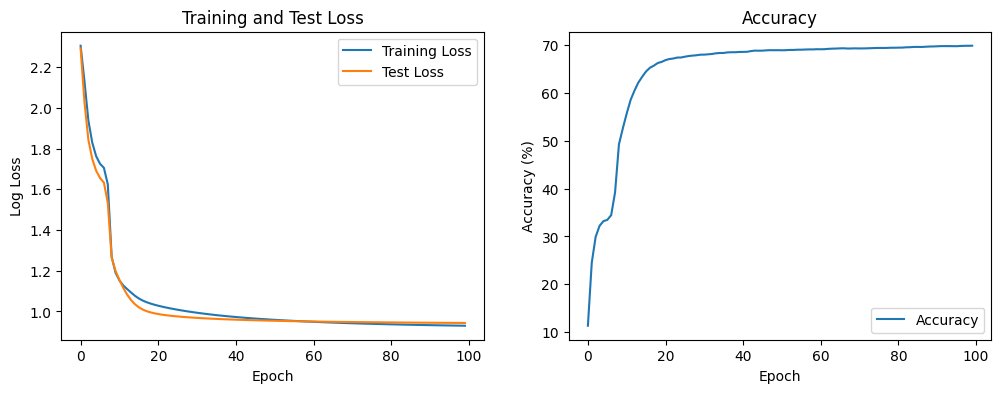

In [14]:
# Plot the training and test losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_train, label='Training Loss')
plt.plot(epochs, loss_test, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

---
# Observation : 

### Graphique de gauche : **Loss d'entraînement et de test**
- **Observation** : Les courbes de perte (loss) pour l'entraînement et le test diminuent significativement au cours des premières époques, puis se stabilisent vers l'époque 40–50.
- **Analyse** :
  - La diminution des pertes indique que le modèle apprend efficacement.
  - La proximité entre les pertes d'entraînement et de test montre que le modèle généralise bien, sans signe évident de sur-apprentissage (overfitting).
  - La stagnation des courbes de perte indique que le modèle atteint une sorte de limite dans sa capacité d'apprentissage pour cette architecture ou ce jeu de données.

### Graphique de droite : **Précision (Accuracy)**
- **Observation** : La précision augmente rapidement pendant les premières époques, puis commence à se stabiliser autour des époques 40–50, atteignant environ 70 %.
- **Analyse** :
  - L'augmentation rapide de la précision au début montre que le modèle apprend efficacement.
  - La stabilisation autour de 70 % indique une limitation potentielle liée à l'architecture, aux données ou à la méthode d'entraînement.

---

#Tester les performances avec Initialisation des poids avec une loi normale de moyenne nulle et d’écart type à fixer et qui est  10^-1

In [15]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def forward(batch, Wh, bh, Wy, by):
    """ Entrées:
        - batch: un batch de n images de MNIST au format vecteur (n, 784)
        - Wh: une matrice de poids entrée -> couche cachée
        - bh: un vecteur de biais pour la couche cachée
        - Wy: une matrice de poids couche cachée -> sortie
        - by: un vecteur de biais pour la sortie

        Renvoie:
        - Y_pred: prédictions de sortie
        - H: activations de la couche cachée
    """
    # À compléter
    H = sigmoid(batch @ Wh + bh)
    Y_pred=softmax(H@Wy+by)
    return Y_pred, H


def backward(Y_pred, Y, X, H,Wy):
    """ Entrées:
        - Y_pred: batch de vecteur des prédictions (one-hot)
        - Y: batch de vecteur des étiquettes (one-hot)
        - X: batch d'images (au format vectoriel (n, 784))
        - H: matrice des activations cachées

        Renvoie:
        - gradWy: gradient de l'erreur (entropie croisée) par rapport à Wy
        - gradby: gradient de l'erreur (entropie croisée) par rapport à by
        - gradWh: gradient de l'erreur (entropie croisée) par rapport à Wh
        - gradbh: gradient de l'erreur (entropie croisée) par rapport à bh
    """
    n = len(X)

    # Calcul du gradient par rapport à Wy et by
    grad_output = Y_pred - Y
    gradWy = np.dot(H.T, grad_output)
    gradby = np.sum(grad_output, axis=0, keepdims=True)

    # Calcul du gradient par rapport à Wh et bh
    grad_hidden = np.dot(grad_output, Wy.T) * (H * (1 - H))
    gradWh = np.dot(X.T, grad_hidden)
    gradbh = np.sum(grad_hidden, axis=0, keepdims=True)

    # Normalisation des gradients par le nombre d'exemples
    gradWy /= n
    gradby /= n
    gradWh /= n
    gradbh /= n

    return gradWy, gradby, gradWh, gradbh


def accuracy_mlp( images, labels,wh, bh, wy, by):
    pred, h = forward(images, wh, bh, wy, by)
    return np.where(pred.argmax(axis=1) != labels.argmax(axis=1), 0., 1.).mean()*100.0

def acc(X_batch,Y_batch,wh,bh,wy,by):
    pred,h=forward(X_batch,wh,bh,wy,by)
    predicted_labels = np.argmax(pred, axis=1)
    true_labels = np.argmax(Y_batch, axis=1)
    accuracy = np.mean(predicted_labels==true_labels) * 100.0
    return accuracy


import numpy as np
N, d = X_train.shape # N exemples, dimension d
hidden_size = 100 # Nombre de neurones de la couche cachée
# Initialisation des poids et des biais
from sklearn.metrics import log_loss


sigma_normal = 0.1
Wy = np.random.randn(hidden_size, K)*sigma_normal
Wh = np.random.randn(d, hidden_size)*sigma_normal
by = np.zeros((1, K))
bh = np.zeros((1, hidden_size))


K = 10
L = 100
eta=0.1


n_epochs = 100 # Nombre d'epochs de la descente de gradient
eta = 1e-1 # Learning rate (pas d'apprentissage)
batch_size = 100 # Taille du lot
n_batches = int(float(N) / batch_size)

# Allocation des matrices pour stocker les valeurs des gradients
gradWy = np.zeros((hidden_size, K))
gradWh = np.zeros((d, hidden_size))
gradby = np.zeros((1, K))
gradbh = np.zeros((1, hidden_size))
accuracy=[]
loss_train=[]
loss_test=[]

for epoch in range(n_epochs):
    for batch_idx in range(n_batches):
        X_batch = X_train[batch_idx * batch_size:(batch_idx + 1) * batch_size]
        Y_batch = Y_train[batch_idx * batch_size:(batch_idx + 1) * batch_size]

        # ********* À compléter **********
        # FORWARD PASS : calculer la prédiction y à partir des paramètres courants pour les images du batch
        Y_pred,H=forward(X_batch,Wh,bh,Wy,by)
        # BACKWARD PASS :
        gradWy, gradby, gradWh, gradbh=backward(Y_pred, Y_batch, X_batch, H,Wy)
        Wy=Wy-eta*gradWy
        by=by-eta*gradby
        Wh=Wh-eta*gradWh
        bh=bh-eta*gradbh


        # 1) calculer les gradients de l'erreur par rapport à W et b
        # 2) mettre à jour les paramètres W et b selon la descente de gradient
    logloss_train = log_loss(Y_batch, Y_pred)
    pred_test,h=forward(X_test,Wh,bh,Wy,by)
    logloss_test=log_loss(Y_test,pred_test)
    loss_train.append(logloss_train)
    loss_test.append(logloss_test)
    accur=acc(X_test,Y_test,Wh,bh,Wy,by)
    accuracy.append(accur)
    #print(f'======= Epoch {epoch}/{n_epochs}')
    print(f'======= Epoch {epoch}/{n_epochs} ======= Accuracy {accur}')

 

======= Epoch 0/100 ======= Accuracy 87.48
======= Epoch 1/100 ======= Accuracy 89.97
======= Epoch 2/100 ======= Accuracy 91.07
======= Epoch 3/100 ======= Accuracy 91.63
======= Epoch 4/100 ======= Accuracy 92.02
======= Epoch 5/100 ======= Accuracy 92.47
======= Epoch 6/100 ======= Accuracy 92.86
======= Epoch 7/100 ======= Accuracy 93.23
======= Epoch 8/100 ======= Accuracy 93.53
======= Epoch 9/100 ======= Accuracy 93.74
======= Epoch 10/100 ======= Accuracy 93.94
======= Epoch 11/100 ======= Accuracy 94.12
======= Epoch 12/100 ======= Accuracy 94.26
======= Epoch 13/100 ======= Accuracy 94.52000000000001
======= Epoch 14/100 ======= Accuracy 94.65
======= Epoch 15/100 ======= Accuracy 94.77
======= Epoch 16/100 ======= Accuracy 94.91000000000001
======= Epoch 17/100 ======= Accuracy 95.02000000000001
======= Epoch 18/100 ======= Accuracy 95.19999999999999
======= Epoch 19/100 ======= Accuracy 95.22
======= Epoch 20/100 ======= Accuracy 95.34
======= Epoch 21/100 ======= Accuracy 

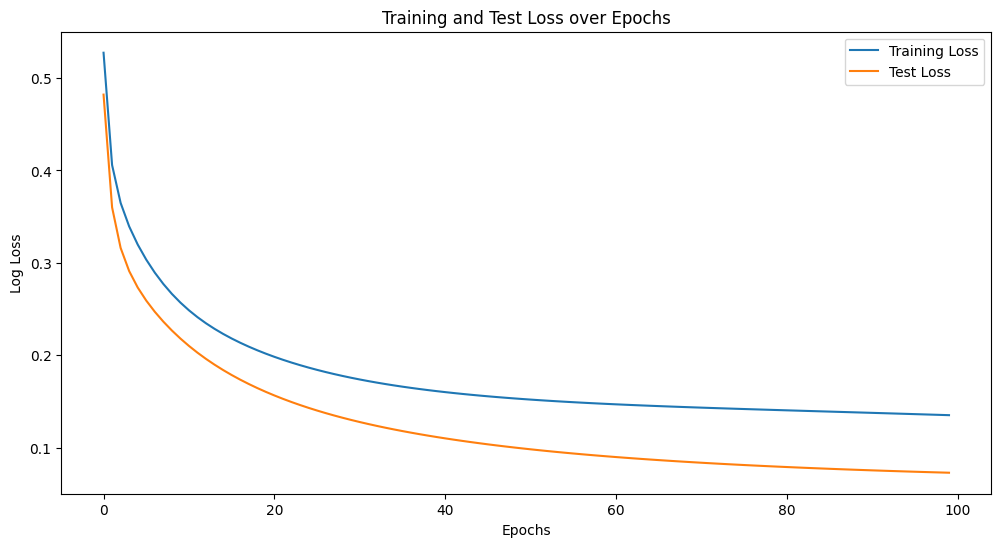

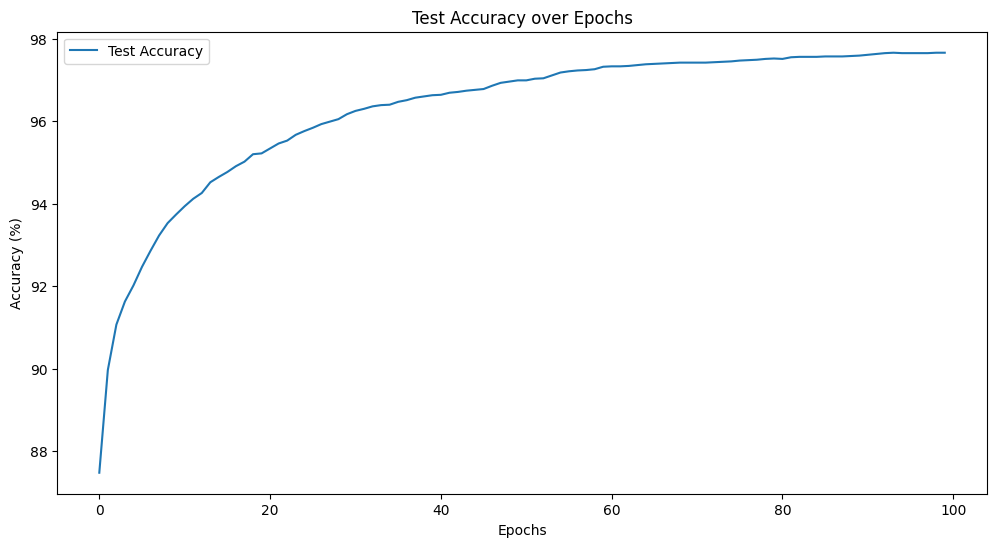

In [16]:
# Plot the training and test loss
plt.figure(figsize=(12, 6))
plt.plot(range(n_epochs), loss_train, label='Training Loss')
plt.plot(range(n_epochs), loss_test, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.show()
# Plot the accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(n_epochs), accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.show()

#Tester les performances avec Initialisation des poids selon Xavier/Glorot

In [17]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def forward(batch, Wh, bh, Wy, by):
    """ Entrées:
        - batch: un batch de n images de MNIST au format vecteur (n, 784)
        - Wh: une matrice de poids entrée -> couche cachée
        - bh: un vecteur de biais pour la couche cachée
        - Wy: une matrice de poids couche cachée -> sortie
        - by: un vecteur de biais pour la sortie

        Renvoie:
        - Y_pred: prédictions de sortie
        - H: activations de la couche cachée
    """
    # À compléter
    H = sigmoid(batch @ Wh + bh)
    Y_pred=softmax(H@Wy+by)
    return Y_pred, H


def backward(Y_pred, Y, X, H,Wy):
    """ Entrées:
        - Y_pred: batch de vecteur des prédictions (one-hot)
        - Y: batch de vecteur des étiquettes (one-hot)
        - X: batch d'images (au format vectoriel (n, 784))
        - H: matrice des activations cachées

        Renvoie:
        - gradWy: gradient de l'erreur (entropie croisée) par rapport à Wy
        - gradby: gradient de l'erreur (entropie croisée) par rapport à by
        - gradWh: gradient de l'erreur (entropie croisée) par rapport à Wh
        - gradbh: gradient de l'erreur (entropie croisée) par rapport à bh
    """
    n = len(X)

    # Calcul du gradient par rapport à Wy et by
    grad_output = Y_pred - Y
    gradWy = np.dot(H.T, grad_output)
    gradby = np.sum(grad_output, axis=0, keepdims=True)

    # Calcul du gradient par rapport à Wh et bh
    grad_hidden = np.dot(grad_output, Wy.T) * (H * (1 - H))
    gradWh = np.dot(X.T, grad_hidden)
    gradbh = np.sum(grad_hidden, axis=0, keepdims=True)

    # Normalisation des gradients par le nombre d'exemples
    gradWy /= n
    gradby /= n
    gradWh /= n
    gradbh /= n

    return gradWy, gradby, gradWh, gradbh


def accuracy_mlp( images, labels,wh, bh, wy, by):
    pred, h = forward(images, wh, bh, wy, by)
    return np.where(pred.argmax(axis=1) != labels.argmax(axis=1), 0., 1.).mean()*100.0

def acc(X_batch,Y_batch,wh,bh,wy,by):
    pred,h=forward(X_batch,wh,bh,wy,by)
    predicted_labels = np.argmax(pred, axis=1)
    true_labels = np.argmax(Y_batch, axis=1)
    accuracy = np.mean(predicted_labels==true_labels) * 100.0
    return accuracy


import numpy as np
N, d = X_train.shape # N exemples, dimension d
K = 10 # Nombre de classes
L = 100 # Nombre de neurones dans la couche cachée

# Initialisation des poids avec l'initialisation de Xavier/Glorot
sqrt_6_over_sqrt_in_out = np.sqrt(6) / np.sqrt(d + L) # Xavier initialization range
Wh = np.random.uniform(-sqrt_6_over_sqrt_in_out, sqrt_6_over_sqrt_in_out, (d, L))
Wy = np.random.uniform(-sqrt_6_over_sqrt_in_out, sqrt_6_over_sqrt_in_out, (L, K))

# Les biais sont toujours initialisés à zéro
bh = np.zeros((1, L))
by = np.zeros((1, K))

eta = 1e-1 # Learning rate

n_epochs = 100 # Nombre d'epochs
batch_size = 100 # Taille du lot
n_batches = N // batch_size

accuracy = []
loss_train = []
loss_test = []

for epoch in range(n_epochs):
    for batch_idx in range(n_batches):
        X_batch = X_train[batch_idx * batch_size:(batch_idx + 1) * batch_size]
        Y_batch = Y_train[batch_idx * batch_size:(batch_idx + 1) * batch_size]


        Y_pred,H=forward(X_batch,Wh,bh,Wy,by)
        # BACKWARD PASS :
        gradWy, gradby, gradWh, gradbh=backward(Y_pred, Y_batch, X_batch, H,Wy)
        Wy=Wy-eta*gradWy
        by=by-eta*gradby
        Wh=Wh-eta*gradWh
        bh=bh-eta*gradbh


        # 1) calculer les gradients de l'erreur par rapport à W et b
        # 2) mettre à jour les paramètres W et b selon la descente de gradient
    logloss_train = log_loss(Y_batch, Y_pred)
    pred_test,h=forward(X_test,Wh,bh,Wy,by)
    logloss_test=log_loss(Y_test,pred_test)
    loss_train.append(logloss_train)
    loss_test.append(logloss_test)
    accur=acc(X_test,Y_test,Wh,bh,Wy,by)
    accuracy.append(accur)
    #print(f'======= Epoch {epoch}/{n_epochs}')
    print(f'======= Epoch {epoch}/{n_epochs} ======= Accuracy {accur}')

    

======= Epoch 0/100 ======= Accuracy 86.53999999999999
======= Epoch 1/100 ======= Accuracy 89.75999999999999
======= Epoch 2/100 ======= Accuracy 90.75999999999999
======= Epoch 3/100 ======= Accuracy 91.51
======= Epoch 4/100 ======= Accuracy 91.94
======= Epoch 5/100 ======= Accuracy 92.36
======= Epoch 6/100 ======= Accuracy 92.67999999999999
======= Epoch 7/100 ======= Accuracy 92.97
======= Epoch 8/100 ======= Accuracy 93.27
======= Epoch 9/100 ======= Accuracy 93.53
======= Epoch 10/100 ======= Accuracy 93.74
======= Epoch 11/100 ======= Accuracy 94.01
======= Epoch 12/100 ======= Accuracy 94.16
======= Epoch 13/100 ======= Accuracy 94.27
======= Epoch 14/100 ======= Accuracy 94.42
======= Epoch 15/100 ======= Accuracy 94.6
======= Epoch 16/100 ======= Accuracy 94.76
======= Epoch 17/100 ======= Accuracy 94.95
======= Epoch 18/100 ======= Accuracy 95.08
======= Epoch 19/100 ======= Accuracy 95.17999999999999
======= Epoch 20/100 ======= Accuracy 95.32000000000001
======= Epoch 2

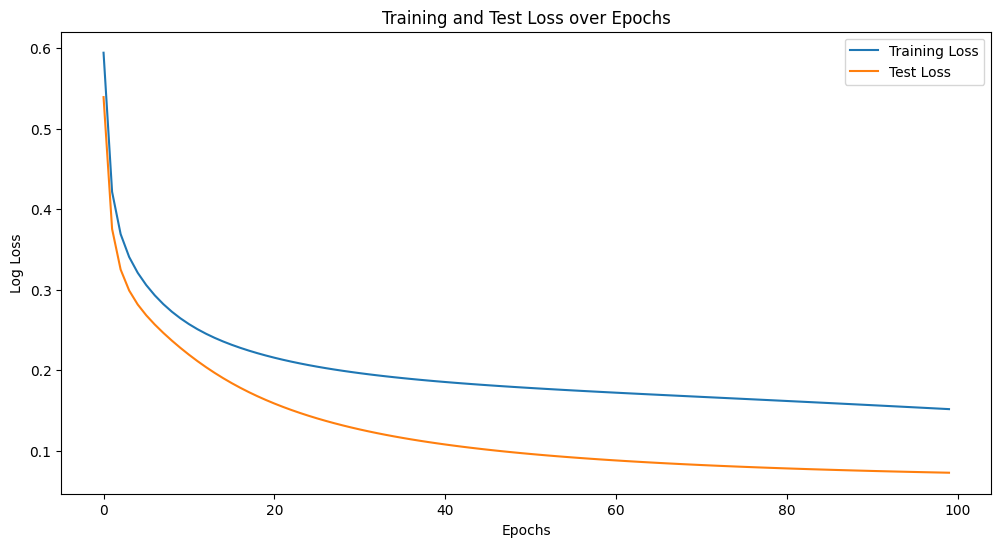

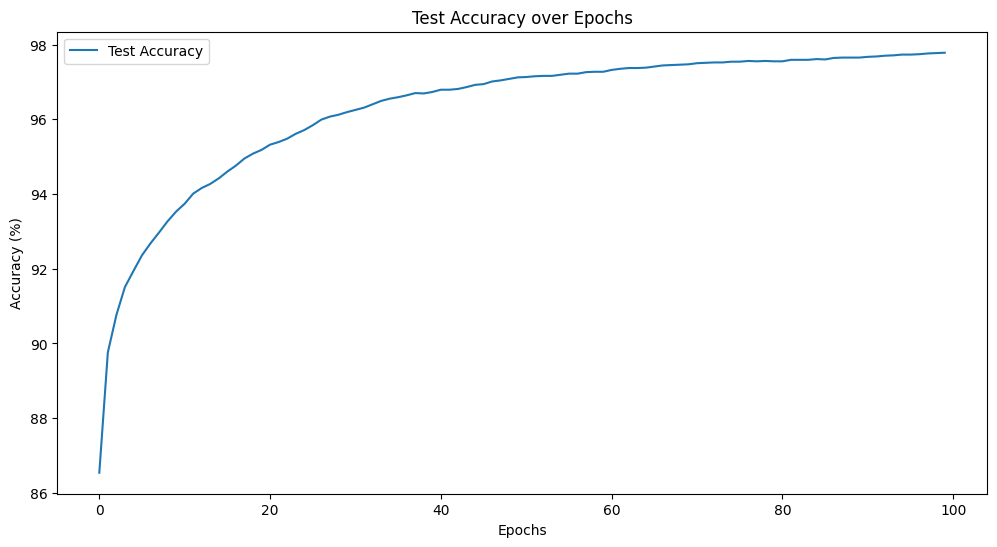

In [18]:
# Plot the training and test loss
plt.figure(figsize=(12, 6))
plt.plot(range(n_epochs), loss_train, label='Training Loss')
plt.plot(range(n_epochs), loss_test, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.show()
# Plot the accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(n_epochs), accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.legend()
plt.show()

#Tester les performances avec Initialisation des poids selon une distribution normale selon Xavier/Glorot

In [19]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def forward(batch, Wh, bh, Wy, by):
    """ Entrées:
        - batch: un batch de n images de MNIST au format vecteur (n, 784)
        - Wh: une matrice de poids entrée -> couche cachée
        - bh: un vecteur de biais pour la couche cachée
        - Wy: une matrice de poids couche cachée -> sortie
        - by: un vecteur de biais pour la sortie

        Renvoie:
        - Y_pred: prédictions de sortie
        - H: activations de la couche cachée
    """
    # À compléter
    H = sigmoid(batch @ Wh + bh)
    Y_pred=softmax(H@Wy+by)
    return Y_pred, H


def backward(Y_pred, Y, X, H,Wy):
    """ Entrées:
        - Y_pred: batch de vecteur des prédictions (one-hot)
        - Y: batch de vecteur des étiquettes (one-hot)
        - X: batch d'images (au format vectoriel (n, 784))
        - H: matrice des activations cachées

        Renvoie:
        - gradWy: gradient de l'erreur (entropie croisée) par rapport à Wy
        - gradby: gradient de l'erreur (entropie croisée) par rapport à by
        - gradWh: gradient de l'erreur (entropie croisée) par rapport à Wh
        - gradbh: gradient de l'erreur (entropie croisée) par rapport à bh
    """
    n = len(X)

    # Calcul du gradient par rapport à Wy et by
    grad_output = Y_pred - Y
    gradWy = np.dot(H.T, grad_output)
    gradby = np.sum(grad_output, axis=0, keepdims=True)

    # Calcul du gradient par rapport à Wh et bh
    grad_hidden = np.dot(grad_output, Wy.T) * (H * (1 - H))
    gradWh = np.dot(X.T, grad_hidden)
    gradbh = np.sum(grad_hidden, axis=0, keepdims=True)

    # Normalisation des gradients par le nombre d'exemples
    gradWy /= n
    gradby /= n
    gradWh /= n
    gradbh /= n

    return gradWy, gradby, gradWh, gradbh


def accuracy_mlp( images, labels,wh, bh, wy, by):
    pred, h = forward(images, wh, bh, wy, by)
    return np.where(pred.argmax(axis=1) != labels.argmax(axis=1), 0., 1.).mean()*100.0

def acc(X_batch,Y_batch,wh,bh,wy,by):
    pred,h=forward(X_batch,wh,bh,wy,by)
    predicted_labels = np.argmax(pred, axis=1)
    true_labels = np.argmax(Y_batch, axis=1)
    accuracy = np.mean(predicted_labels==true_labels) * 100.0
    return accuracy


import numpy as np
N, d = X_train.shape # N exemples, dimension d
K = 10 # Nombre de classes
L = 100 # Nombre de neurones dans la couche cachée

# Initialisation des poids avec l'initialisation de Xavier/Glorot
std_dev = np.sqrt(2.0 / (d + L)) # Pour une activation sigmoïde
Wh = np.random.randn(d, L) * std_dev
Wy = np.random.randn(L, K) * std_dev

# Les biais sont toujours initialisés à zéro
bh = np.zeros((1, L))
by = np.zeros((1, K))

eta = 1e-1 # Learning rate

n_epochs = 100 # Nombre d'epochs
batch_size = 100 # Taille du lot
n_batches = N // batch_size

accuracy = []
loss_train = []
loss_test = []

for epoch in range(n_epochs):
    for batch_idx in range(n_batches):
        X_batch = X_train[batch_idx * batch_size:(batch_idx + 1) * batch_size]
        Y_batch = Y_train[batch_idx * batch_size:(batch_idx + 1) * batch_size]

        # ********* À compléter **********
        # FORWARD PASS : calculer la prédiction y à partir des paramètres courants pour les images du batch
        Y_pred,H=forward(X_batch,Wh,bh,Wy,by)
        # BACKWARD PASS :
        gradWy, gradby, gradWh, gradbh=backward(Y_pred, Y_batch, X_batch, H,Wy)
        Wy=Wy-eta*gradWy
        by=by-eta*gradby
        Wh=Wh-eta*gradWh
        bh=bh-eta*gradbh


        # 1) calculer les gradients de l'erreur par rapport à W et b
        # 2) mettre à jour les paramètres W et b selon la descente de gradient
    logloss_train = log_loss(Y_batch, Y_pred)
    pred_test,h=forward(X_test,Wh,bh,Wy,by)
    logloss_test=log_loss(Y_test,pred_test)
    loss_train.append(logloss_train)
    loss_test.append(logloss_test)
    accur=acc(X_test,Y_test,Wh,bh,Wy,by)
    accuracy.append(accur)
    #print(f'======= Epoch {epoch}/{n_epochs}')
    print(f'======= Epoch {epoch}/{n_epochs} ======= Accuracy {accur}')



======= Epoch 0/100 ======= Accuracy 86.83999999999999
======= Epoch 1/100 ======= Accuracy 89.87
======= Epoch 2/100 ======= Accuracy 90.72
======= Epoch 3/100 ======= Accuracy 91.58
======= Epoch 4/100 ======= Accuracy 91.96
======= Epoch 5/100 ======= Accuracy 92.38
======= Epoch 6/100 ======= Accuracy 92.82000000000001
======= Epoch 7/100 ======= Accuracy 93.13
======= Epoch 8/100 ======= Accuracy 93.43
======= Epoch 9/100 ======= Accuracy 93.67999999999999
======= Epoch 10/100 ======= Accuracy 93.82000000000001
======= Epoch 11/100 ======= Accuracy 94.08
======= Epoch 12/100 ======= Accuracy 94.28
======= Epoch 13/100 ======= Accuracy 94.43
======= Epoch 14/100 ======= Accuracy 94.59
======= Epoch 15/100 ======= Accuracy 94.67
======= Epoch 16/100 ======= Accuracy 94.84
======= Epoch 17/100 ======= Accuracy 95.0
======= Epoch 18/100 ======= Accuracy 95.16
======= Epoch 19/100 ======= Accuracy 95.24000000000001
======= Epoch 20/100 ======= Accuracy 95.30999999999999
======= Epoch 2

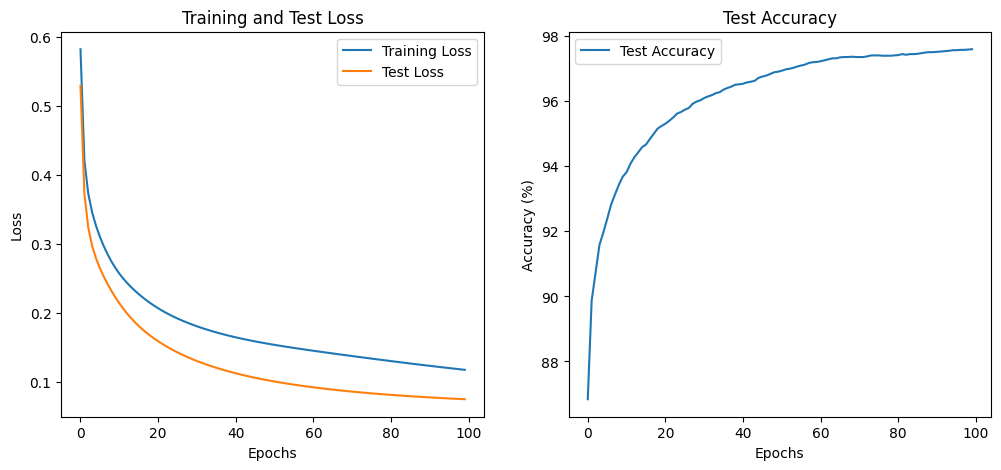

In [20]:


# Plot the training and test loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(n_epochs), loss_train, label='Training Loss')
plt.plot(range(n_epochs), loss_test, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(range(n_epochs), accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()
plt.show()

---
# Conclusion : 


Ces méthodes améliorent les performances en brisant la symétrie des poids, en maintenant les gradients à des niveaux appropriés pour éviter les problèmes d’explosion ou de disparition des gradients, et en facilitant la convergence du réseau. Les initialisations aléatoires, comme celles basées sur une distribution normale ou la méthode de Xavier, introduisent une variabilité essentielle qui permet à chaque neurone d’apprendre différents aspects des données.

Par ailleurs, l’initialisation Xavier se distingue par son efficacité à maintenir la variance des activations et des gradients à travers les couches, un aspect crucial pour les architectures profondes. Ces observations soulignent l’importance d’une bonne initialisation des poids pour assurer le bon fonctionnement et des performances optimales des réseaux de neurones, notamment dans le cas de structures complexes.

En conclusion, une initialisation adéquate des poids est un élément clé pour favoriser une meilleure généralisation et atteindre des performances élevées.


---